# Spotify Hit Songs Classification

## Business Problem

There could be a number of factors that determine whether a song will be a hit or not. If we know what these factors are, we may be able to better predict how popular a song will be and therefore improve features such as user recommendations.

By looking at Spotify data, can we use certain features to predict whether or not a song will be a hit? What features are most predictive of hit songs?

## Data Understanding

To begin, I import all the neccessary tools I will need for this project as well as the dataset I will be working with. I also explore the dataset to get a better understanding of the data it contains.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv('data/dataset-of-10s.csv')
data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1


In [4]:
data.isna().sum()

track               0
artist              0
uri                 0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

In [5]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6.398000e+03,6398.000000,6398.000000,6398.000000,6398.000000
mean,0.568163,0.667756,5.283526,-7.589796,0.645514,0.098018,0.216928,0.165293,0.196700,0.443734,122.353871,2.367042e+05,3.930916,41.028399,10.316505,0.500000
std,0.191103,0.240721,3.606216,5.234592,0.478395,0.097224,0.296835,0.318736,0.166148,0.245776,29.847389,8.563698e+04,0.377469,19.568827,3.776011,0.500039
min,0.062200,0.000251,0.000000,-46.655000,0.000000,0.022500,0.000000,0.000000,0.016700,0.000000,39.369000,2.985300e+04,0.000000,0.000000,2.000000,0.000000
25%,0.447000,0.533000,2.000000,-8.425000,0.000000,0.038825,0.008533,0.000000,0.096800,0.240000,98.091250,1.932068e+05,4.000000,28.059135,8.000000,0.000000
50%,0.588000,0.712500,5.000000,-6.096500,1.000000,0.057200,0.067050,0.000017,0.126000,0.434000,121.070000,2.212465e+05,4.000000,36.265365,10.000000,0.500000
75%,0.710000,0.857000,8.000000,-4.601250,1.000000,0.112000,0.311000,0.057650,0.249000,0.628000,141.085000,2.593165e+05,4.000000,48.292538,12.000000,1.000000
max,0.981000,0.999000,11.000000,-0.149000,1.000000,0.956000,0.996000,0.995000,0.982000,0.976000,210.977000,1.734201e+06,5.000000,213.154990,88.000000,1.000000


In [224]:
#normalize the data
num_data = data.copy().drop(columns=['track', 'artist', 'uri'])
num_data = num_data.apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
num_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000
mean,0.550678,0.668342,0.480321,0.840004,0.645514,0.080898,0.217800,0.166123,0.186470,0.454646,0.483572,0.121367,0.786183,0.192482,0.096704,0.500000
std,0.207991,0.241023,0.327838,0.112557,0.478395,0.104150,0.298027,0.320338,0.172121,0.251819,0.173928,0.050246,0.075494,0.091806,0.043907,0.500039
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.418807,0.533416,0.181818,0.822044,0.000000,0.017488,0.008567,0.000000,0.082979,0.245902,0.342188,0.095845,0.800000,0.131637,0.069767,0.000000
50%,0.572268,0.713141,0.454545,0.872113,1.000000,0.037172,0.067319,0.000017,0.113229,0.444672,0.476091,0.112297,0.800000,0.170136,0.093023,0.500000
75%,0.705050,0.857822,0.727273,0.904265,1.000000,0.095876,0.312249,0.057940,0.240651,0.643443,0.592723,0.134634,0.800000,0.226561,0.116279,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
data['target'].value_counts()

1    3199
0    3199
Name: target, dtype: int64

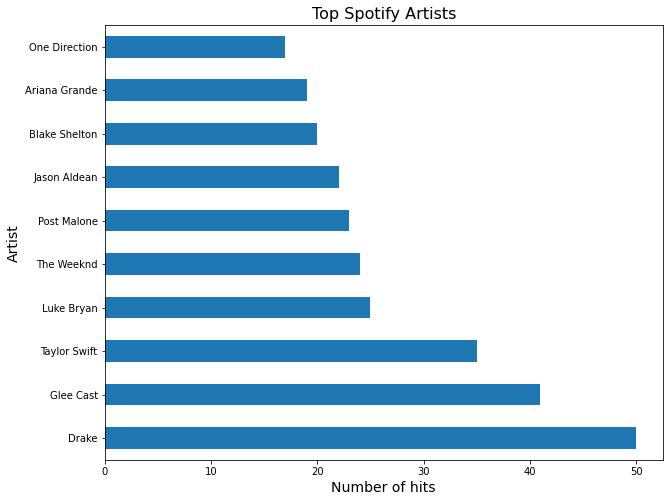

In [7]:
# bar plot of artist with the most hit songs (top artists)

top_artists = data.groupby('artist')['target'].sum().sort_values(ascending=False).nlargest(10)
top_artists.plot(kind='barh', figsize=(10,8))
plt.title('Top Spotify Artists', fontsize=16)
plt.xlabel('Number of hits', fontsize=14)
plt.ylabel('Artist', fontsize=14);


In [8]:
data.groupby('artist')['target'].sum().sort_values(ascending=False).nlargest(10).sum()

276

In [9]:
data.groupby('artist').sum()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
artist,,,,,,,,,,,,,,,,
"""Weird Al"" Yankovic",0.897,0.430,7,-12.759,1,0.0551,0.011800,0.000000,0.0473,0.964,121.987,223120,4,34.48070,13,1
//Tense//,0.704,0.844,5,-9.378,1,0.0308,0.000047,0.442000,0.2660,0.656,123.011,326632,4,106.36427,9,0
10 Years,0.470,0.882,6,-3.906,1,0.0638,0.003470,0.000002,0.3720,0.328,164.040,199680,4,36.50841,8,0
11 Acorn Lane,2.393,2.409,11,-15.412,2,0.2808,0.171900,0.862550,0.4060,2.345,377.954,644714,12,151.59299,32,0
2 Chainz,1.835,1.206,18,-12.063,1,0.5615,0.873300,0.000000,0.1358,1.241,227.414,414853,8,131.47432,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ìxtahuele,0.755,0.551,7,-6.191,0,0.0487,0.723000,0.001200,0.2060,0.707,135.681,186640,4,43.01471,9,0
クラシックバレエ クラブ,0.956,0.527,2,-29.320,2,0.1225,1.986000,1.785000,0.2207,1.476,225.795,163338,7,49.28445,11,0
リアムMAZE1981,1.548,1.510,10,-16.082,1,0.1020,0.009850,0.002581,0.1577,1.339,229.051,670575,8,77.02388,33,0


In [10]:
(276/3199)*100

8.627696155048453

The top 10 artists in this dataset with the most hit songs are Drake, Glee Cast, Taylor Swift, Luke Bryan, The Weeknd, Post Malone, Jason Aldean, Blake Shelton, Ariana Grande, and One Direction. Together, these artists have about 8.63% of the hit songs in this particular dataset.

In [11]:
mode_data = data.copy()
mode_data['mode'] = data['mode'].replace({1: 'Major', 0:'Minor'})

mode_data['mode'].value_counts()

Major    4130
Minor    2268
Name: mode, dtype: int64

In [12]:
data['mode'][data['target']==1].sum()

2114

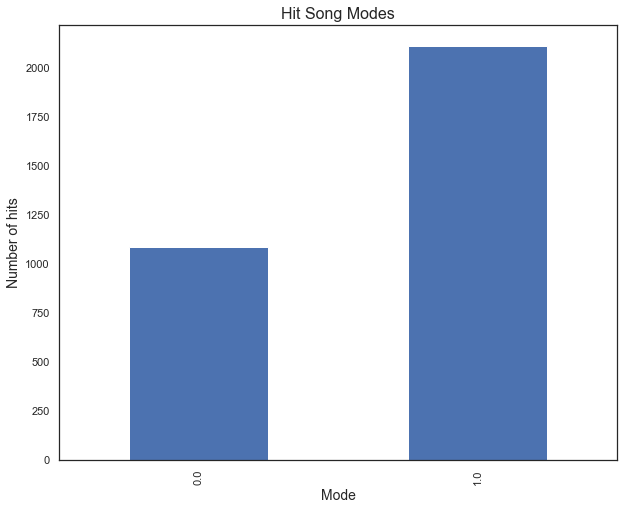

In [225]:
# Mode bar plot (number of hits in major vs. minor)
major_minor = num_data.groupby('mode')['target'].sum()
major_minor.plot(kind='bar', figsize=(10,8))
plt.title('Hit Song Modes', fontsize=16)
plt.xlabel('Mode', fontsize=14)
plt.ylabel('Number of hits', fontsize=14);



In [14]:
major = (2114/3199)*100
minor = 100-((2268/3199)*100)
print("Major:", major, "Minor:", minor)

Major: 66.08315098468272 Minor: 29.102844638949676


Of the songs that were a hit, about 66.08% were major and about 29.10% were minor.

<Axes: xlabel='target'>

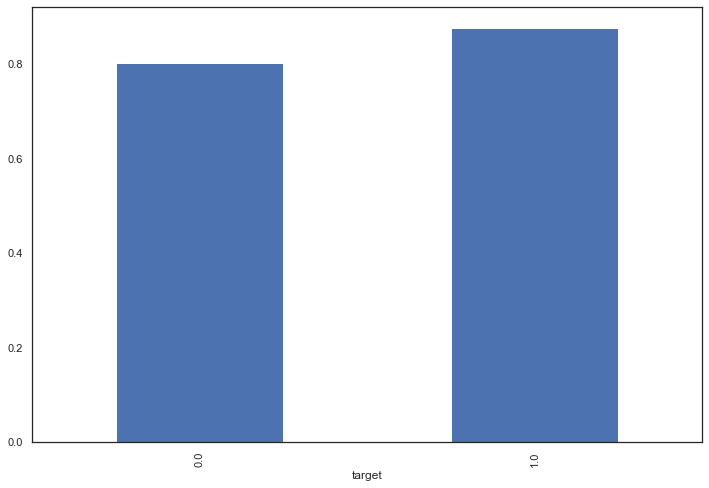

In [226]:
# histogram (loudness?)

volume = num_data.groupby('target')['loudness'].mean()
volume.plot(kind='bar', y='loudness', x='target')



To generally get a better idea of which features of the data might be related to the target, I look at the Pearson correlations.

In [227]:
# correlation?
num_data.corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
danceability,1.000000,0.069645,0.012429,0.300576,-0.057280,0.200090,-0.206865,-0.371334,-0.107581,0.494136,-0.056197,-0.224803,0.178671,-0.078254,-0.162908,0.384486
energy,0.069645,1.000000,0.028703,0.774536,0.004929,0.119194,-0.734853,-0.288263,0.231393,0.281031,0.216886,-0.009228,0.175984,-0.001224,-0.074466,0.060701
key,0.012429,0.028703,1.000000,0.010824,-0.146063,0.022796,-0.021271,-0.013049,0.021785,0.019572,0.009259,0.011028,-0.008462,0.001960,0.002512,0.005548
loudness,0.300576,0.774536,0.010824,1.000000,0.021064,0.122028,-0.648717,-0.533671,0.126807,0.324985,0.194467,-0.094598,0.207436,-0.042665,-0.111469,0.327471
mode,-0.057280,0.004929,-0.146063,0.021064,1.000000,-0.090107,0.011424,-0.037132,-0.011590,0.018198,0.032180,-0.042125,0.014125,-0.007967,-0.030129,0.032021
speechiness,0.200090,0.119194,0.022796,0.122028,-0.090107,1.000000,-0.134226,-0.148649,0.121075,0.053836,0.117813,-0.071826,0.063656,0.001857,-0.035077,0.097783
acousticness,-0.206865,-0.734853,-0.021271,-0.648717,0.011424,-0.134226,1.000000,0.315563,-0.149926,-0.166253,-0.182050,-0.039567,-0.191607,0.001477,0.024583,-0.184479
instrumentalness,-0.371334,-0.288263,-0.013049,-0.533671,-0.037132,-0.148649,0.315563,1.000000,-0.049879,-0.334662,-0.083487,0.183696,-0.133629,0.093847,0.114927,-0.499624
liveness,-0.107581,0.231393,0.021785,0.126807,-0.011590,0.121075,-0.149926,-0.049879,1.000000,-0.016562,0.038555,0.040219,0.026185,0.043099,0.008406,-0.062612
valence,0.494136,0.281031,0.019572,0.324985,0.018198,0.053836,-0.166253,-0.334662,-0.016562,1.000000,0.053572,-0.248445,0.117049,-0.103274,-0.168675,0.203774


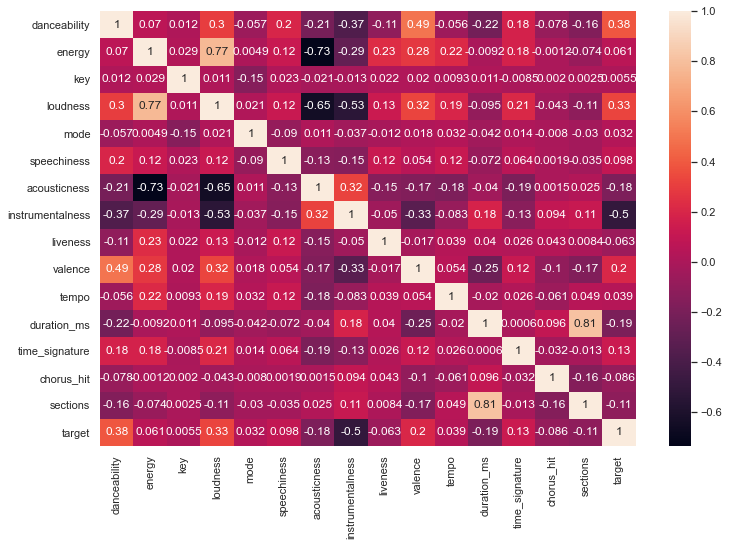

In [228]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(data.corr(), annot=True);

<ipython-input-229-87d7db78736a>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


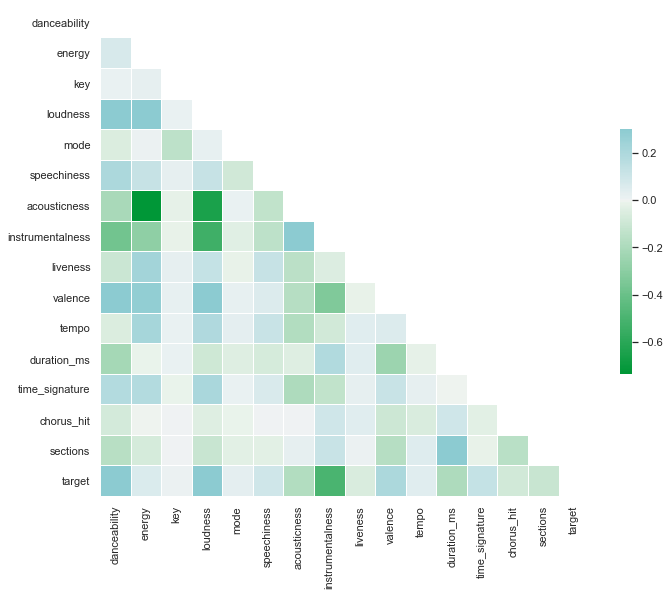

In [229]:
sns.set(style="white")
corr = num_data.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(150,200,215, n=3, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Just by looking at this heatmap of the different features' correlations, we can see that the features that are most positively correlated with the target (whether or not the song is a hit) are danceability, loudness, valence, and time signature. Instrumentalness has a strong negative correlation with the target.

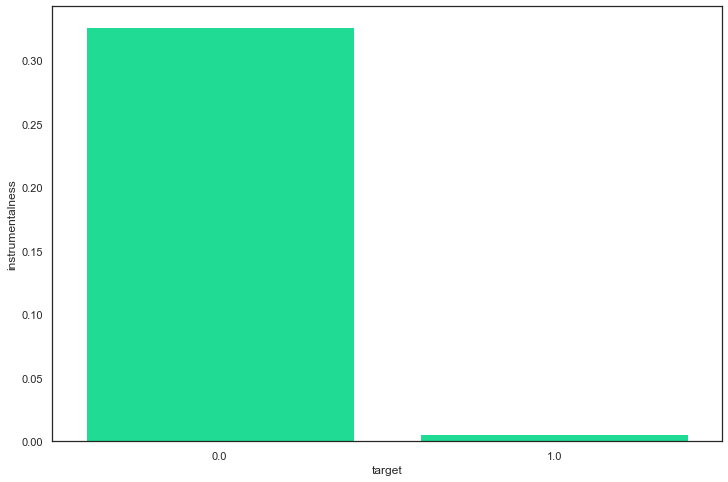

In [231]:
instrumentalness = num_data.copy()
instrumentalness  = instrumentalness.groupby('target')['instrumentalness'].mean().reset_index()

# Instrumentalness scatter plot
sns.barplot(data=instrumentalness, y='instrumentalness', x ='target', color='mediumspringgreen');

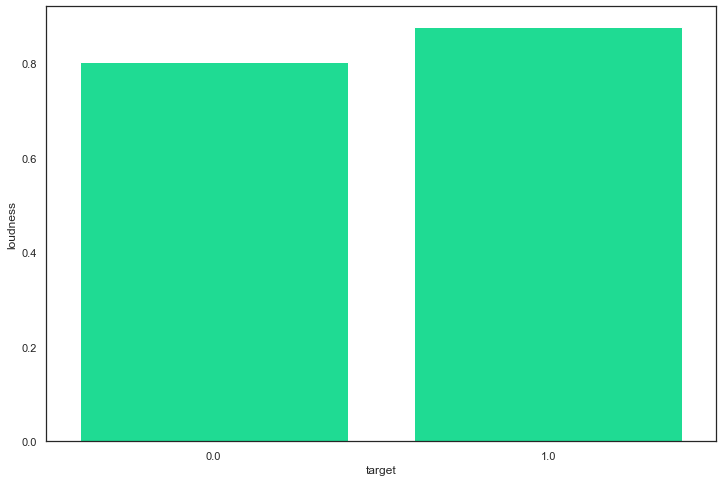

In [232]:
# loudness
volume = num_data.copy()
volume = volume.groupby('target')['loudness'].mean().reset_index()

sns.barplot(data=volume, y='loudness', x ='target', color='mediumspringgreen');

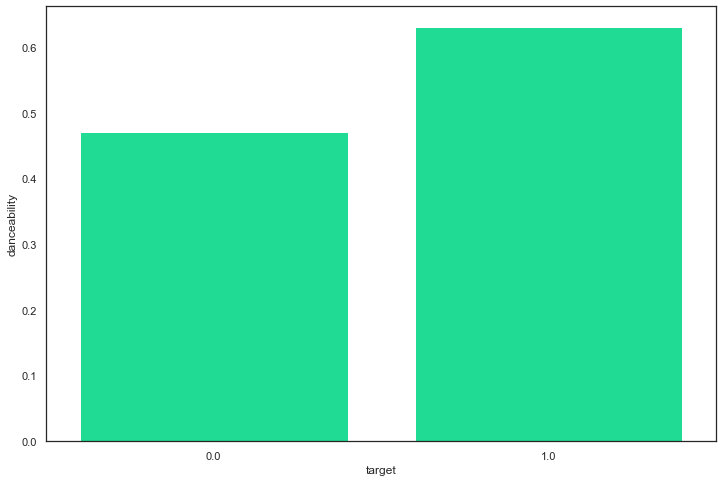

In [234]:
# danceability
dance = num_data.copy()
dance = dance.groupby('target')['danceability'].mean().reset_index()

sns.barplot(data=dance, y='danceability', x ='target', color='mediumspringgreen');

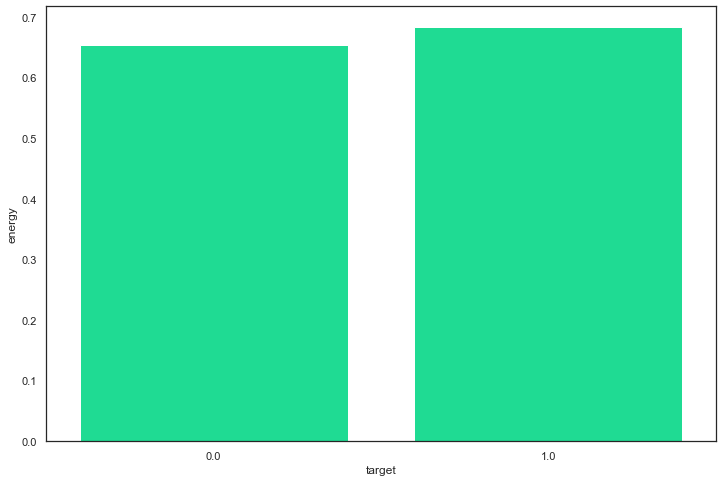

In [235]:
# energy
energy = num_data.copy()
energy = energy.groupby('target')['energy'].mean().reset_index()

sns.barplot(data=energy, y='energy', x ='target', color='mediumspringgreen');

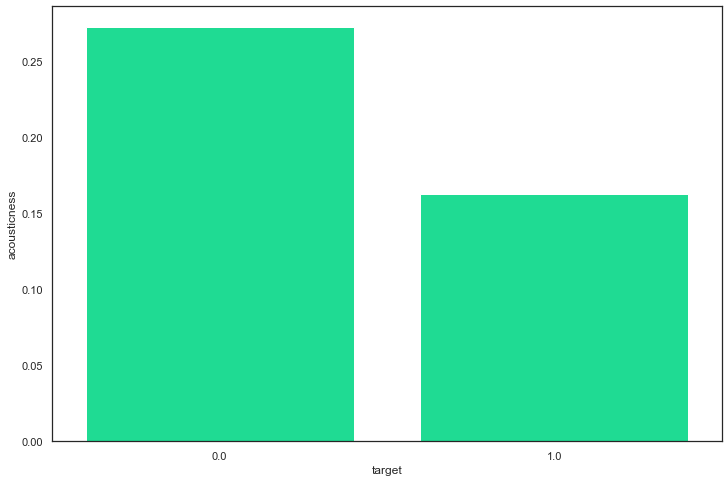

In [236]:
# acousticness
acoustic = num_data.copy()
acoustic = acoustic.groupby('target')['acousticness'].mean().reset_index()

sns.barplot(data=acoustic, y='acousticness', x ='target', color='mediumspringgreen');

## Data Preparation

To compare later models to, first a baseline model must be created. I am using a single decision tree for the baseline model. In order to do this, I begin by assigning the target variable to y and the other features to X, normalizing the data, and then perfomring a train-test split to evaluate the model with.

(Explain why you used the following classification metrics)(precision, accuracy, and AUC)
- better to have a FN than a FP
    - "We'd rather only recommend good quality songs"

In [21]:
X = data.drop(columns=['target', 'uri', 'artist', 'track'], axis=1)
y = data['target']
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
0,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10
1,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9
2,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9
3,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7
4,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

## Modeling

In this section I build and evaluate my baseline decision tree model, then make changes to that model as well as try a more complex model (random forests) to see if it will perform better at correctly classifying the songs as hits or not.

For this business problem, we have a goal of recommending hit songs to Spotify users and therefore it would be better to incorrectly identify a hit song as not a hit, than to incorrectly identify a "flop" song as a hit. In other words, a false negative from our model is better than a false positive. We want to only recommend good-quality songs. For these reasons, the metrics used to evaluate the following models include accuracy, precision, and AUC.

In [24]:
# Building a "regular" tree as a baseline

baseline_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
baseline_tree.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [25]:
y_hat_train = baseline_tree.predict(X_train)
y_hat_test = baseline_tree.predict(X_test)


In [26]:
# Precision score
print("Training Precision for Decision Tree Classifier: {:.4}%".format(precision_score(y_train, y_hat_train) * 100))
print("Testing Precision for Decision Tree Classifier: {:.4}%".format(precision_score(y_test, y_hat_test) * 100))

print("Training Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_train, y_hat_train) * 100))
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, y_hat_test) * 100))


Training Precision for Decision Tree Classifier: 78.93%
Testing Precision for Decision Tree Classifier: 76.83%
Training Accuracy for Decision Tree Classifier: 82.76%
Testing Accuracy for Decision Tree Classifier: 80.25%


In [27]:
# Plot the decision tree

#fig, axes = plt.subplots(nrows =1, ncols =1, figsize=(5,5), dpi =300)
#tree.plot_tree(baseline_tree,
#              feature_names = X.columns,
#              class_names = np.unique(y).astype('str'),
#              filled=True)
#plt.show()

In [28]:
# Check the AUC of predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8030099179468428

###### AUC interpretation: 
Because of the fact that for this business problem we would rather have a false negative (fail to identify a song as a hit when it really is one) than a false positive (incorrectly identify a song as a hit), looking at the AUC (Area Under the Curve) can provide us with more information on the rate of false negatives to false positives. We want this value to be as close to 1.0 as possible.

Our baseline model has an AUC value of about 0.8.

In [31]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[601 206]
 [110 683]]


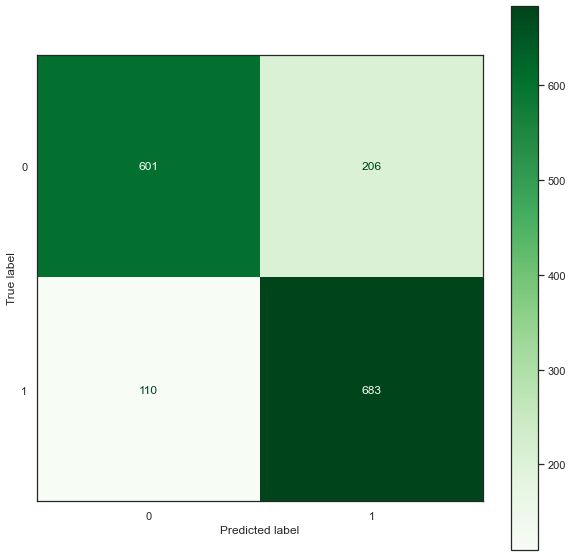

In [240]:
#CM Visualization:
fig, ax = plt.subplots(figsize=(10,10))
cm_1 = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = baseline_tree.classes_)
cm_1.plot(cmap=plt.cm.Greens, ax=ax);

###### Confusion Matrix interpretation: 
This model has 601 true positives, 110 false positives, 683 true negatives, and 206 false negatives. For this data/business problem, it is worse to have a false positive than a false negative and there are less FPs than FNs, which is a good thing.

Next, I examine how important the different features of the data are for this baseline model.

In [33]:
baseline_tree.feature_importances_

array([0.03137781, 0.12121346, 0.00222707, 0.06339033, 0.        ,
       0.00553143, 0.        , 0.72431934, 0.00508173, 0.04098987,
       0.00312003, 0.        , 0.        , 0.00274894, 0.        ])

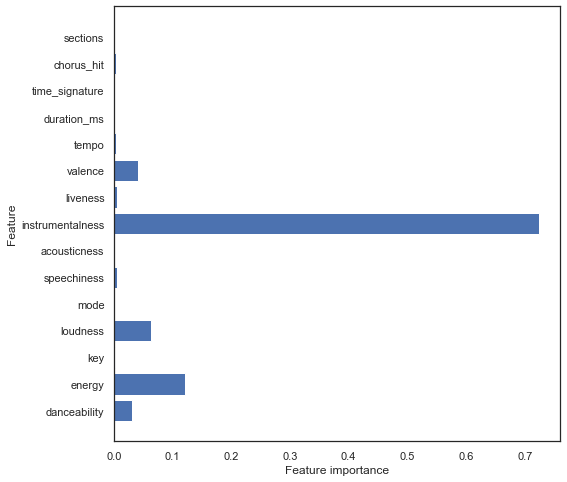

In [34]:
# Plotting feature importances
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(baseline_tree)


The most important features to this baseline model are instrumentalness, energy, loudness, valence, and danceability.

Next, to try and improve this baseline model, I perform a GridSearchCV to search for the optimal combination of parameters that can make our decision tree perform the best and see if it is better than the baseline model's performance.

In [35]:
dt_param_grid ={
    "max_depth": [None,5,10],
    "min_samples_leaf": [2, 4, 6, 8],
    "max_features": [5, 7, 10]
    
}


In [36]:
# Baseline DT grid search
dt_grid_search = GridSearchCV(baseline_tree , dt_param_grid, cv=3, return_train_score=True)

dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5),
             param_grid={'max_depth': [None, 5, 10], 'max_features': [5, 7, 10],
                         'min_samples_leaf': [2, 4, 6, 8]},
             return_train_score=True)

In [37]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_["mean_train_score"])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 87.74%
Mean Test Score: 80.62%
Best Parameter Combination Found During Grid Search:


{'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 8}

Based on this grid search, the optimal value for minimum leaf sample size is 2,
and the optimal maximum tree depth is 5, 
and the optimal maximum number of features is 7.


In [38]:
# Train a classifier with optimal values identified above
dt = DecisionTreeClassifier(
                            max_depth=5,
                            min_samples_leaf=6,
                            max_features = 7,
                            random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8056741844297454

In [39]:
y_hat_train2 = dt.predict(X_train)
y_hat_test2 = dt.predict(X_test)


In [40]:
print("Training precision score for decision tree model with tuned hyperparameters: {:.4}%".format(precision_score(y_train, y_hat_train2) * 100))
print("Testing precision score for decision tree model with tuned hyperparameters: {:.4}%".format(precision_score(y_test, y_hat_test2) * 100))

print("Training accuracy score for decision tree model with tuned hyperparameters: {:.4}%".format(accuracy_score(y_train, y_hat_train2)* 100))
print("Testing accuracy score for decision tree model with tuned hyperparameters:{:.4}%".format(accuracy_score(y_test, y_hat_test2)* 100))

Training precision score for decision tree model with tuned hyperparameters: 78.22%
Testing precision score for decision tree model with tuned hyperparameters: 76.17%
Training accuracy score for decision tree model with tuned hyperparameters: 82.7%
Testing accuracy score for decision tree model with tuned hyperparameters:80.5%


Changing these parameters did not really improve the baseline model, the precision and accuracy scores are about the same, with the precision scores being only slighty worse.

### Building a random forests model:

In [41]:
#Fit a random forests model
forest = RandomForestClassifier(max_features='sqrt',
                               max_samples = 0.5,
                               random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.5, random_state=42)

In [42]:
y_hat_train3 = forest.predict(X_train)
y_hat_test3 = forest.predict(X_test)


In [43]:
print("Training precision score for random forests model: {:.4}%".format(precision_score(y_train, y_hat_train3) * 100))
print("Testing precision score for random forests model: {:.4}%".format(precision_score(y_test, y_hat_test3) * 100))

print("Training accuracy score for random forests model: {:.4}%".format(accuracy_score(y_train, y_hat_train3)* 100))
print("Testing accuracy score for random forests model: {:.4}%".format(accuracy_score(y_test, y_hat_test3)* 100))


Training precision score for random forests model: 95.51%
Testing precision score for random forests model: 80.32%
Training accuracy score for random forests model: 96.71%
Testing accuracy score for random forests model: 83.19%


###### Interpretation:
This random forests model had both a higher precision score and a higher accuracy score than our baseline decision tree. However, it appears that the model may be overfitting. 

 Now, we create a parameter grid specific to our random forest classifier to try and improve its performance:

In [44]:

rf_param_grid = {
    "max_depth": [None, 5],
    "max_features": [5, 7, 10],
    'min_samples_leaf': [4, 6, 8, 10]
}


In [45]:
# Now perform the GridSearchCV
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 84.39%

Optimal Parameters: {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 6}


In [46]:
# Train a new random forests model with optimal values identified above
rf = RandomForestClassifier(max_depth=None,
                            max_features = 10,
                            min_samples_leaf=6,
                            random_state=42)
rf.fit(X_train, y_train)
y_train_rf = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8329465849729119

In [47]:
print("Training precision score for random forests model with tuned hyperparameters: {:.4}%".format(precision_score(y_train, y_train_rf) * 100))
print("Testing precision score for random forests model with tuned hyperparameters: {:.4}%".format(precision_score(y_test, y_pred_rf) * 100))

print("Training accuracy score for random forests model with tuned hyperparameters: {:.4}%".format(accuracy_score(y_train, y_train_rf)* 100))
print("Testing accuracy score for random forests model with tuned hyperparameters:{:.4}%".format(accuracy_score(y_test, y_pred_rf)* 100))

Training precision score for random forests model with tuned hyperparameters: 90.48%
Testing precision score for random forests model with tuned hyperparameters: 79.93%
Training accuracy score for random forests model with tuned hyperparameters: 93.29%
Testing accuracy score for random forests model with tuned hyperparameters:83.25%


These metrics are better, however there is still overfitting. If you change the maximum depth to 5, the AUC score goes down a little bit, but there is less overfitting.

In [48]:
# Which model performed best on the test set?
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print("Decision tree grid search: ", dt_score)
print("Random forest grid search: ", rf_score)

Decision tree grid search:  0.80625
Random forest grid search:  0.825


The GridSearch for this random forests model also performed better than the one for our baseline decision tree model.

In [49]:
rf2 = RandomForestClassifier(max_depth=5,
                            max_features = 10,
                            min_samples_leaf=6,
                            random_state=42)
rf2.fit(X_train, y_train)
y_train_rf2 = rf2.predict(X_train)
y_pred_rf2 = rf2.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_rf2)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8194689905945922

In [50]:
print("Training precision score for random forests model with tuned hyperparameters: {:.4}%".format(precision_score(y_train, y_train_rf2) * 100))
print("Testing precision score for random forests model with tuned hyperparameters: {:.4}%".format(precision_score(y_test, y_pred_rf2) * 100))

print("Training accuracy score for random forests model with tuned hyperparameters: {:.4}%".format(accuracy_score(y_train, y_train_rf2)* 100))
print("Testing accuracy score for random forests model with tuned hyperparameters:{:.4}%".format(accuracy_score(y_test, y_pred_rf2)* 100))

Training precision score for random forests model with tuned hyperparameters: 79.35%
Testing precision score for random forests model with tuned hyperparameters: 77.13%
Training accuracy score for random forests model with tuned hyperparameters: 84.45%
Testing accuracy score for random forests model with tuned hyperparameters:81.88%


<em>This will be our <b>final model</b></em>, with:
- an AUC score of about 0.82, which is slightly better than our baseline AUC score of about 0.80 
- a testing precision score of about 77.58%, which is slighly better than our baseline testing precision of about 76.83% 
- a testing accuracy score of about 81.81%, which is slightly better than our baseline accuracy score of 80.25%

In [51]:
cnf_matrix2 = confusion_matrix(y_test, y_pred_rf2)
print('Confusion Matrix:\n', cnf_matrix2)

Confusion Matrix:
 [[595 212]
 [ 78 715]]


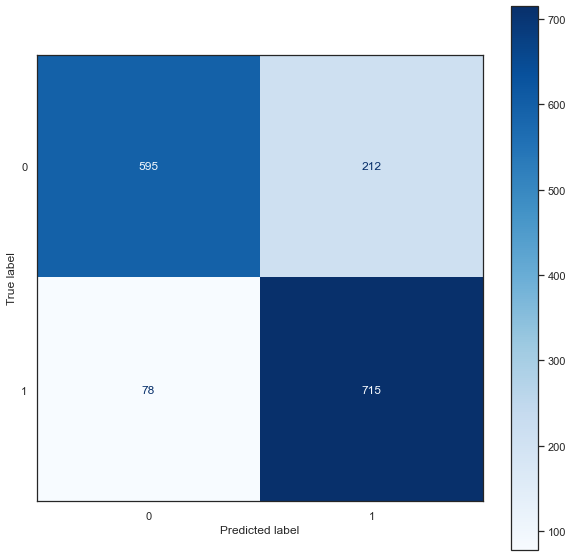

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
cm_2 = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix2, display_labels = rf2.classes_)
cm_2.plot(cmap=plt.cm.Blues, ax=ax);


###### Confusion Matrix interpretation: 
This model has 505 true positives, 78 false positives, 715 true negatives, and 212 false negatives. 
Once again there are less False Positives than False Negatives, which is what we want. Additionally, there are less of both FPs and FNs than there were in the baseline model.


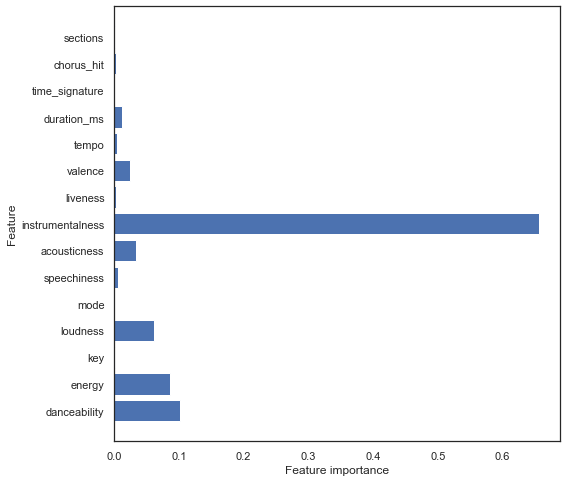

In [79]:
# Feature importances of final model:

plot_feature_importances(rf2)

The most important features for this model are instrumentalness, danceability, energy, loudness, and acousticness. These are mostly the same features that were most important to our baseline model, except acousticness is more important here.

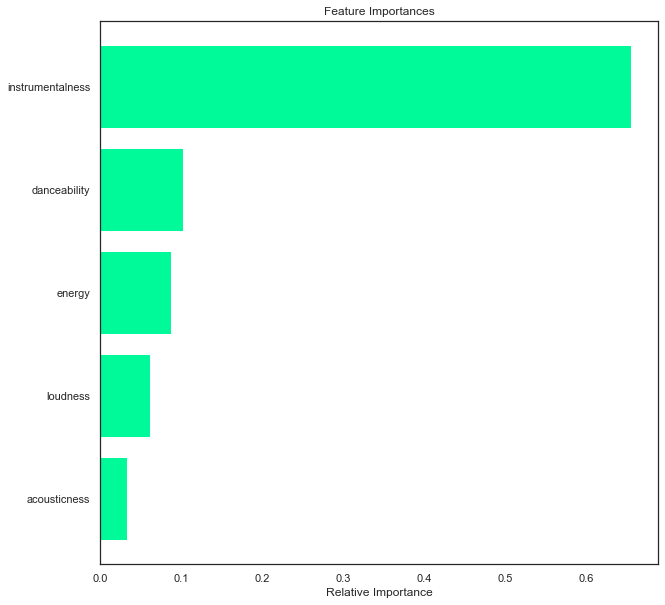

In [242]:
features = X.columns
importances = rf2.feature_importances_
indices = np.argsort(importances)

num_features = 5 

plt.figure(figsize=(10,10))
plt.title('Feature Importances')

plt.barh(range(num_features), importances[indices[-num_features:]], color='mediumspringgreen', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

## Evaluation

Our final model is about 81.8% accurate and about 77.6% precise in correctly identifying songs as hits or not. The rate of false negatives to false positives (AUC) was about 0.82. This is an improvement to our baseline model which was a single decision tree before hyperparameter tuning that was about 80.3% accurate, about 76.8% precise in classifying our target and had an AUC of about 0.81. 

## Recommendations/Next Steps

Reccommendations:
- context that this info can be used for stakeholder
- suggestions for what input variables the business could modify to achieve certain target results
    - in future: look at data from other decades to compare trends 
    - could also look at genres